In [258]:
import pandas as pd
from os import path

# Step 1: Preprocessing

* filenames = the names of the files containing the master student data 
* projects = the names of the files containing the master projects data

In [259]:
filenames = {}
for year in range(2007,2017):
    for semester in [1,2,3]:
        filename = 'data/master_%d_%d.csv' % (year, semester)
        filenames[(year,semester)] = filename

projects = {}
for year in range(2007,2017):
    for semester in ['automne','printemps']:
        filename = 'data/projet_master_%d_%s.csv' % (year, semester)
        if(path.isfile(filename)):
            projects[(year,semester)] = filename

master_students is a dictionary which maps each possible master semester (1, 2, or 3) to a pandas dataframe containing all the students in all the years which were listed under the respective semester

Each of the tables are indexed by the Sciper number of the student and unncesary or redundant columns like 'Unnamed: 0' and 'semester' are dropped.

Additionally the year column which contains the start of the academic year for the listed student will be renamed to year_sx, where x is the semester number: 1, 2 or 3. The renaming helps in keeping track of the student's information in later steps.

In [260]:
master_students = {}
for key in filenames.keys():
    master_students[key[1]] = []
for key,filename in filenames.items():
    master_students[key[1]].append(pd.read_csv(filename, header=0, index_col='No Sciper'))
for semester,tables in master_students.items():
    master_students[semester] = pd.concat(tables)
    master_students[semester].drop(['Unnamed: 0', 'semester'],axis=1,inplace=True)
    master_students[semester] = master_students[semester].rename(columns = {'year':('year_s'+str(semester))})
#master_students[1].head()

Further preprocessing involves dropping entries which figure in the 'Type Echange' column, reserved for exchange students.

In [261]:
# remove students with an entry in the exchange column
# and remove column 'Type Echange' as it is irrelevant now
for semester,tables in master_students.items():
    master_students[semester] = \
        master_students[semester][master_students[semester].loc[:,'Type Echange'].isnull() == True]
    master_students[semester] = master_students[semester].dropna(axis=1, how='all')
#frames[1]

Similarly as before we collect all the master projects under one dataframe, indexed by the Sciper number of the students, while renaming the 'year' column to 'year_pr'

In [262]:
# Collecting all the master projects

master_projects = []
for key,filename in projects.items():
    master_projects.append(pd.read_csv(filename, header=0, index_col='No Sciper'))
master_projects = pd.concat(master_projects)
#master_projects
master_projects.drop(['Unnamed: 0'],axis=1,inplace=True)
master_projects = master_projects.rename(columns = {'year':'year_pr'})


Remove entries which feature an entry in the 'Type Echange' column in case there are any and drop columns which are entirely filled with NaN values

In [263]:
# remove entries which appear under 'Type Echange'
master_projects = master_projects[master_projects.loc[:,'Type Echange'].isnull() == True]
master_projects = master_projects.dropna(axis=1, how='all')

In [264]:
#master_projects

# Step 2: Merging

In order to not have duplicate columns after merging, we keep from one table only the columns which are not in the other table.

For example below we keep from master_students[1] (i.e. the table containing the master students registered in the first semester) only the columns that are not in master_students[2]. By doing this we also introduce the assumption that in columns like Specialization or Mineur only the last entry is relevant.

We merge based on the Sciper number, meaning we only keep students that figure under both semesters (1 and 2)

In [265]:
# keep the students in the first 2 semesters
cols_to_use = master_students[1].columns.difference(master_students[2].columns)
master_studs_1_2 = pd.merge(master_students[2], 
                        master_students[1][cols_to_use], left_index=True, right_index=True, how='inner')
#master_studs_1_2.head()

For now we decided to keep only the students in the first and second semester, but in the third semester.

In [266]:
id12 = master_studs_1_2.index.difference(master_students[3].index)
master_studs_1_2_only = master_studs_1_2.ix[id12]
#master_studs_1_2_only

Following the previous step we only keep the students from the first and second semester that also have a master project entry

In [267]:
# All students who did 1st and 2nd sem and the master project

cols_to_use = master_studs_1_2_only.columns.difference(master_projects.columns)
master_studs_1_2_only_project = pd.merge(master_projects, master_studs_1_2_only[cols_to_use],
                                    left_index=True, right_index=True, how='inner')
#master_studs_1_2_only_project

After having the students with semesters 1, 2 and a master project, we focus on the students that also figure in the 3rd semester. 

Here similarly to the above approach we keep the columns from the table, which contains students with a 1st and 2nd semester, that are not in the table containing students from the 3rd semester.

In [268]:
# find the students in all 3 semesters
cols_to_use = master_studs_1_2.columns.difference(master_students[3].columns)
master_studs_1_2_3 = pd.merge(master_students[3], 
                        master_studs_1_2[cols_to_use], left_index=True, right_index=True, how='inner')
#master_studs_1_2_3

We divided the students which figure under all 3 master semesters in 2 cases:

* the students who figure in the 'Statut' column as 'Stage' and we assume that they are doing or done their master project during this period. Because of this and for convenience we add the column 'year_pr' = 'year_s3' (i.e. equals to the column corresponding to the year in which the student was registered in its 3rd semester) and the column 'semester' = 'automne' as the 3rd semester takes place during fall. In addition we keep those 'Stage' students without an entry in the master_projects table

In [301]:
# find the students in all 3 semesters with 'Stage' in the 3rd semester
master_studs_1_2_3_stage = master_studs_1_2_3[master_studs_1_2_3['Statut'] == 'Stage']

# Here we assume that the students are doing their master project at the same time with their Stage
master_studs_1_2_3_stage = master_studs_1_2_3_stage.assign(year_pr = master_studs_1_2_3_stage['year_s3'])
master_studs_1_2_3_stage = master_studs_1_2_3_stage.assign(semester = 'automne')

# keep those not referenced in the master_projects table
id123 = master_studs_1_2_3_stage.index.difference(master_projects.index)
master_studs_1_2_3_stage = master_studs_1_2_3_stage.ix[id123]
#master_studs_1_2_3_stage

* the second case consists in gathering the students which are listed to have a master project

In [303]:
# Students in semesters 1,2,3 with a master project
cols_to_use = master_projects.columns.difference(master_studs_1_2_3.columns)
master_studs_1_2_3_project = pd.merge(master_studs_1_2_3, master_projects[cols_to_use],
                                    left_index=True, right_index=True, how='inner')
#master_studs_1_2_3_project.head()

In [304]:
# Test if there are overlaps between master_studs_1_2_3_stage and master_studs_1_2_3_project
master_studs_1_2_3_test = pd.merge(master_studs_1_2_3_stage, master_studs_1_2_3_project,
                                    left_index=True, right_index=True, how='inner')
master_studs_1_2_3_test # should be empty

,Civilité_x,Mineur_x,Nom Prénom_x,Spécialisation_x,Statut_x,year_s3_x,year_s1_x,year_s2_x,year_pr_x,semester_x,Civilité_y,Mineur_y,Nom Prénom_y,Spécialisation_y,Statut_y,year_s3_y,year_s1_y,year_s2_y,semester_y,year_pr_y
No Sciper,,,,,,,,,,,,,,,,,,,,


# Step 3: Putting the tables together

In [271]:
master_students_final = [master_studs_1_2_only_project, master_studs_1_2_3_project, master_studs_1_2_3_stage]

The master table consists of all students that are viable to be considered as graduated master students

Furthermore we only keep the columns which are needed for the first part of the exercise, i.e. the ones needed to compute the average duration

In [305]:
master = pd.concat(master_students_final)
master = master[['Civilité','Nom Prénom','semester', 'year_pr','year_s1','year_s2','year_s3']]
master = master.drop_duplicates()
#master.head()

Next we group the master table based on the Sciper number (there are students with multiple entries due to different reasons, such as doing their second master semester in different academic years or doing their master projects in different seasons) and aggregate the columns using different functions. For example for semester 1 ('year_s1' column) and for semester 2 ('year_s2' column) we are interested in the mininum, whereas for semester 3 and project year('year_pr') we are interested in the maximum of this aggregation.

In [308]:
#master_group = master.groupby(master.index).min()
master_group = master.groupby(master.index)
master_group = master_group.agg({'Civilité':'last','Nom Prénom':'last','semester':'first','year_pr':'max',
                 'year_s1':'min','year_s2':'min','year_s3':'max'})
master_group.head()

,year_s2,Civilité,year_s1,semester,year_s3,year_pr,Nom Prénom
No Sciper,,,,,,,
146742,2008,Monsieur,2008,printemps,2012.0,2010,Marx Clément
154573,2007,Madame,2007,printemps,2009.0,2009,Benabdallah Zeineb
154706,2007,Monsieur,2007,automne,2008.0,2008,Suter François
159516,2008,Monsieur,2008,printemps,2009.0,2009,Raja Yanick
160213,2007,Monsieur,2008,automne,NaN,2009,Bécholey Alexandre


Following we compute the duration for each student in the above table

In [316]:
def compute_duration(row):
    # the semester variable establishes in which semester the student finished
    semester = ''
    # the last_year variable represents the last year done by the student for masters
    last_year = 0
    
    if(pd.isnull(row.year_s3)):
        # if the row.year_s3 entry is NaN then use the master project year and semester
        last_year = row.year_pr
        semester = row.semester
    else:
        if (row.year_s3 == row.year_pr):
            # 'automne' because even if the master project is finished in spring
            # the third semester happens in fall
            last_year = row.year_pr
            semester = 'automne'
        elif (row.year_s3 < row.year_pr):
            # here we use master project again if the third semester happened before
            last_year = row.year_pr
            semester = row.semester
        else:
            # third semester happened after the master project (such cases did happen)
            last_year = row.year_s3
            semester = 'automne'
        
    if (row.year_s1 <= row.year_s2):
        # even if they are equal semester 1 happened before semester 2 
        # i.e. if semester 1 appears as 2009 it means it happened in fall 2009
        # if semester 2 appears as 2009 it means it happened in spring 2010, as
        # 2009 means the beginning of the academic year
        if(semester == 'printemps'):
            return last_year - row.year_s1 + 1.0 # next academic year
        else:
            return last_year - row.year_s1 + 0.5
    else:
        # The else is for entries in which the student is listed with the
        # 2nd semester before the 1st semester -- might seem strange but there
        # were a few cases
        if(semester == 'automne'):
            return last_year - row.year_s2
        else:
            return last_year - row.year_s2 + 0.5 # next academic year
        
master_group['duration'] = master_group.apply(compute_duration, axis = 1)
master_group = master_group[master_group.duration.notnull()]
master_group.head()

,year_s2,Civilité,year_s1,semester,year_s3,year_pr,Nom Prénom,duration
No Sciper,,,,,,,,
146742,2008,Monsieur,2008,printemps,2012.0,2010,Marx Clément,4.5
154573,2007,Madame,2007,printemps,2009.0,2009,Benabdallah Zeineb,2.5
154706,2007,Monsieur,2007,automne,2008.0,2008,Suter François,1.5
159516,2008,Monsieur,2008,printemps,2009.0,2009,Raja Yanick,1.5
160213,2007,Monsieur,2008,automne,NaN,2009,Bécholey Alexandre,2.0


# Average duration for master students:

In [322]:
master_duration = master_group['duration'].mean()
master_duration

1.8491735537190082

In [323]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

Graduated master students (under the conditions applied above) grouped by gender

Monsieur    213
Madame       29
Name: Civilité, dtype: int64


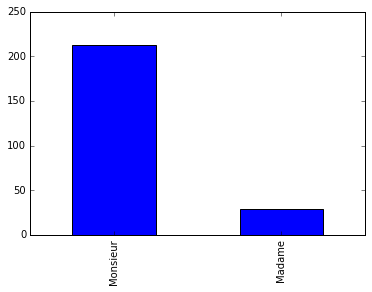

In [319]:
print(master_group["Civilité"].value_counts())
master_group["Civilité"].value_counts().plot(kind='bar')

Graduated master students (under the conditions above) grouped by duration of their studies

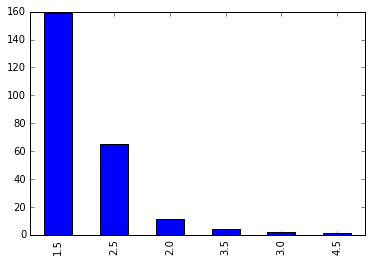

In [320]:
master_group["duration"].value_counts().plot(kind='bar')

In [321]:
# There should not be any case with 1 year
master_group[master_group.duration == 1.0]

,year_s2,Civilité,year_s1,semester,year_s3,year_pr,Nom Prénom,duration
No Sciper,,,,,,,,


# Master Specialization

Among the master students keep the ones which are listed with a specialization

In [328]:
master_spec = [master_studs_1_2_only_project, master_studs_1_2_3_project, master_studs_1_2_3_stage]
master_spec = pd.concat(master_spec)
master_spec = master_spec[master_spec['Spécialisation'].notnull()]
master_spec = master_spec.drop_duplicates()
#master_spec.head()

As before group and aggregate to prepare the data for computing the duration

In [332]:
master_spec = master_spec.groupby(master_spec.index)
master_spec = master_spec.agg({'Civilité':'last','Spécialisation':'last', 'Nom Prénom':'last','semester':'first',
                               'year_pr':'max','year_s1':'min','year_s2':'min','year_s3':'max'})
master_spec.head()

,year_s2,year_s3,Civilité,year_s1,semester,Spécialisation,year_pr,Nom Prénom
No Sciper,,,,,,,,
146742,2008,2012.0,Monsieur,2008,printemps,"Signals, Images and Interfaces",2010,Marx Clément
154573,2007,2009.0,Madame,2007,printemps,Biocomputing,2009,Benabdallah Zeineb
165819,2007,2008.0,Monsieur,2007,printemps,Foundations of Software,2008,Hofer Thomas
169569,2010,2012.0,Monsieur,2010,automne,"Signals, Images and Interfaces",2012,Arévalo Christian
170224,2010,2012.0,Monsieur,2010,automne,"Signals, Images and Interfaces",2012,Margot Alexandre


In [334]:
# ONLY students who have a specialization listed in semester 3

master_spec['duration'] = master_spec.apply(compute_duration, axis = 1)
master_spec = master_spec[master_spec.duration.notnull()]
master_spec.head()

,year_s2,year_s3,Civilité,year_s1,semester,Spécialisation,year_pr,Nom Prénom,duration
No Sciper,,,,,,,,,
146742,2008,2012.0,Monsieur,2008,printemps,"Signals, Images and Interfaces",2010,Marx Clément,4.5
154573,2007,2009.0,Madame,2007,printemps,Biocomputing,2009,Benabdallah Zeineb,2.5
165819,2007,2008.0,Monsieur,2007,printemps,Foundations of Software,2008,Hofer Thomas,1.5
169569,2010,2012.0,Monsieur,2010,automne,"Signals, Images and Interfaces",2012,Arévalo Christian,2.5
170224,2010,2012.0,Monsieur,2010,automne,"Signals, Images and Interfaces",2012,Margot Alexandre,2.5


Grouping the results based on the Specialisation and finding the mean and the number of students listed for the respective specialization.

In [331]:
master_spec_group = master_spec.groupby(['Spécialisation'])
master_spec_group['duration'].agg(['mean', 'size'])

,mean,size
Spécialisation,,
Biocomputing,2.500000,1
Computer Engineering - SP,2.500000,2
Foundations of Software,1.900000,20
Information Security - SP,2.500000,1
Internet computing,2.166667,24
Service science,2.500000,1
"Signals, Images and Interfaces",2.611111,9
Software Systems,2.166667,3
